## Part 3: Volatility arbitrage analysis

In [1289]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from final.random import StandardNormalRNG, GBMPathGenerator, Paths
import final.blackscholes as bs
import final.longstaffschwartz as lsm
from final import volatility as vol
from final import riskfreerate as rf
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brentq
from scipy import optimize
from scipy.interpolate import interp1d

### (a)

To calculate the dividend yield, we will use the formula of 

dividend yield (q) = Total dividends paid / Average stock price

Hence first we need to calculate the sum of dividends paid and divide it by average value of stock price

In [1290]:
# Base location for data 
base_dir = Path('C:/Users/bhanu/OneDrive/Desktop/MFM/Semester 1/Python fm5151/final_starter/starter/data')

stock_data_path = base_dir /'stock.csv'

stock_data = pd.read_csv(stock_data_path)

stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-01-04,130.56,130.65,123.95,126.54,143301900,0.0,0.0
1,2021-01-05,126.04,128.82,125.59,128.11,97664900,0.0,0.0
2,2021-01-06,124.89,128.15,123.58,123.80,155088000,0.0,0.0
3,2021-01-07,125.52,128.72,125.03,128.02,109578200,0.0,0.0
4,2021-01-08,129.50,129.69,127.35,129.13,105158200,0.0,0.0


In [1291]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Filtering for data only in 2022 
stock_filtered = stock_data[(stock_data['Date'] >= '2022-01-01') & (stock_data['Date'] <= '2022-12-31')]

# Calculating total dividends and average stock price for 2022
total_dividends = stock_filtered['Dividends'].sum()
average_stock_price = stock_filtered['Close'].mean()

# Dividends yield q
q = total_dividends / average_stock_price

print(f'Continous dividends yield for AAPL stock as of 2022 : {round(q, 6)*100}%')

Continous dividends yield for AAPL stock as of 2022 : 0.5956%


### (b)

To calculate the risk free rate, we will use linear interpolation corresponding to the given maturity 

In [1292]:
treasury_data_path = base_dir /'treasury.csv'

treasury_data = pd.read_csv(treasury_data_path)

treasury_data.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/2023,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/2023,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/2023,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/2023,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/2023,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


In [1293]:
def risk_free_rate(treasury_data, maturity_in_years):

    # Converting column headers to tenors in fraction years
    tenors = { "1 Mo": 1 / 12, "2 Mo": 2 / 12, "3 Mo": 3 / 12, "4 Mo": 4 / 12, "6 Mo": 6 / 12, 
              "1 Yr": 1, "2 Yr": 2, "3 Yr": 3, "5 Yr": 5, "7 Yr": 7, "10 Yr": 10, "20 Yr": 20, "30 Yr": 30}

    # Extracting the latest treasury data row
    latest_rates = treasury_data.iloc[-1]
    
    # Preparing tenor and rate data for interpolation
    tenors_years = []
    rates = []

    for col, years in tenors.items():
        if col in latest_rates and not pd.isnull(latest_rates[col]):
            tenors_years.append(years)
            rates.append(latest_rates[col])

    # linear interpolation
    interpolation_func = interp1d(tenors_years, rates, kind='linear', fill_value='extrapolate')
    return float(interpolation_func(maturity_in_years))

Importing riskfreerate.py

In [1294]:
from final import riskfreerate as rf

print(f"Risk-free rate for 2 years: {rf.risk_free_rate(treasury_data, maturity_in_years=2)}%")

Risk-free rate for 2 years: 4.4%


## (c)

### (i)

In [1295]:
options_data_path = base_dir /'options.csv'

options_data = pd.read_csv(options_data_path)

options_data.head()

,symbol,quote_date,expiry_date,days_to_expiry,strike_price,call_price,call_volume,put_price,put_volume
0,AAPL,2023-01-03,2023-01-06,3.0,50.0,79.35,0.0,0.01,33.0
1,AAPL,2023-01-03,2023-01-06,3.0,60.0,68.60,0.0,0.01,1.0
2,AAPL,2023-01-03,2023-01-06,3.0,90.0,38.90,0.0,0.01,1.0
3,AAPL,2023-01-03,2023-01-06,3.0,95.0,39.85,0.0,0.01,1565.0
4,AAPL,2023-01-03,2023-01-06,3.0,100.0,24.55,23.0,0.01,116.0


Merging AAPL stock price to options dataframe

In [1296]:
# Merging underlying price data to options data

options_data['quote_date'] = pd.to_datetime(options_data['quote_date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge the stock data with options data based on the 'quote_date'
options_data = options_data.merge( stock_data[['Date', 'Close']],
    left_on='quote_date',
    right_on='Date',
    how='left',
)

# Rename the 'Close' column to 'underlying_price' for clarity
options_data.rename(columns={'Close': 'underlying_price'}, inplace=True)

# Drop the redundant 'Date' column after merge
options_data.drop(columns=['Date'], inplace=True)

# Display the first few rows of the updated options data to confirm the merge
options_data.head()

,symbol,quote_date,expiry_date,days_to_expiry,strike_price,call_price,call_volume,put_price,put_volume,underlying_price
0,AAPL,2023-01-03,2023-01-06,3.0,50.0,79.35,0.0,0.01,33.0,123.77
1,AAPL,2023-01-03,2023-01-06,3.0,60.0,68.60,0.0,0.01,1.0,123.77
2,AAPL,2023-01-03,2023-01-06,3.0,90.0,38.90,0.0,0.01,1.0,123.77
3,AAPL,2023-01-03,2023-01-06,3.0,95.0,39.85,0.0,0.01,1565.0,123.77
4,AAPL,2023-01-03,2023-01-06,3.0,100.0,24.55,23.0,0.01,116.0,123.77


Analysis to determine reasonal number of scenarios to be used

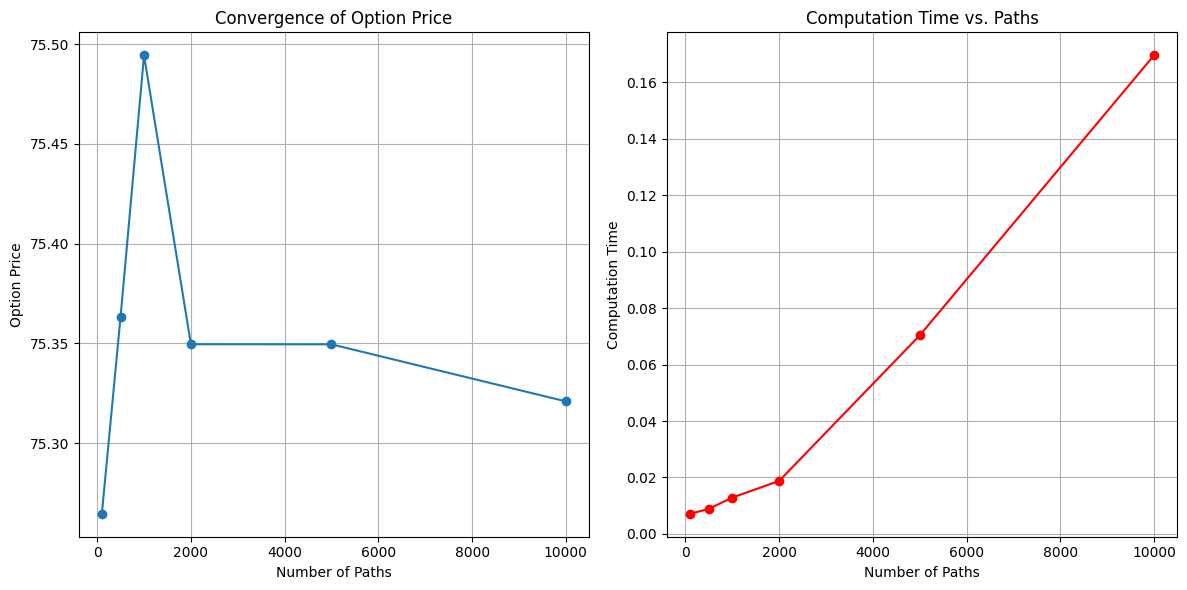

In [1297]:
# testing for just first row (sngle option value)
test_option = options_data.iloc[0] 
T = test_option['days_to_expiry'] / 365  # Time to expiry in years
K = test_option['strike_price']
p = test_option['underlying_price']
#print (p)
rf_rate = rf.risk_free_rate(treasury_data, maturity_in_years=T)

# Dividend yield
q = stock_data['Dividends'].sum() / stock_data['Close'].mean()

# Path generator parameters
n_steps = 50
rng = StandardNormalRNG(seed=50)

# Number of paths to test
path_counts = [100, 500, 1000, 2000, 5000, 10000]
call_prices = []
times = []

for n_paths in path_counts:
    path_gen = GBMPathGenerator(num_paths=n_paths, num_steps=n_steps, s0=p,drift=rf_rate - q, diffusion=0.3, to_time=T, rng=rng)
    
    # Time the calculation
    start_time = time.time()
    price = lsm.lsm_price(K, rf_rate, is_call=True, path_generator=path_gen, polynomial_degree=2)
    end_time = time.time()

    call_prices.append(price)
    times.append(end_time - start_time)

# Plot the results
plt.figure(figsize=(12, 6))

# Price convergence plot
plt.subplot(1, 2, 1)
plt.plot(path_counts, call_prices, marker='o')
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.title("Convergence of Option Price")
plt.grid()

# Computation time plot
plt.subplot(1, 2, 2)
plt.plot(path_counts, times, marker='o', color='red')
plt.xlabel("Number of Paths")
plt.ylabel("Computation Time")
plt.title("Computation Time vs. Paths")
plt.grid()

plt.tight_layout()
plt.show()

Path Analysis to determine a reasonable number of paths for Monte Carlo simulations in LSM pricing.

Method:
- Tested different path counts (100, 500, 1000, 2000, 5000, 10000) on an example option.
- Measured option price stability and computation time.

Results:
- Option price stabilizes at around 2000 paths.
- Beyond 2000 paths, price differences are <0.5%.
- Computation time increases linearly with path count.

Hence using num_paths = 2000 for our analysis

Implied Volatitlity Calculation

Note: I have used antithetic variance reduction technique directly into the generate() function of the class GBMPathGenerator. This technique reduces variance by generating negatively correlated pair of random samples which negates or cancels the overall variance of the simulations

In [1298]:
# Wrapper function for calculating implied volatility using lsm_price
def implied_vol_lsm_price(row, is_call, path_generator, rf_rate, strike_price):
    market_price = row['call_price'] if is_call else row['put_price']
    S0 = row['underlying_price']
    
    def price_diff(sigma):

        # Create new path generator for each sigma to ensure clean state
        rng = StandardNormalRNG(seed=50)
        
        new_path = GBMPathGenerator(num_paths=path_generator.num_paths, num_steps=path_generator.num_steps, s0=S0, drift=rf_rate - q,diffusion=sigma,to_time=path_generator.to_time, rng=rng)
        
        # Calculate option price using LSM
        price = lsm.lsm_price(strike_price, rf_rate, is_call, new_path, polynomial_degree=2, debug=False)
                
        return price - market_price

    # Initial broad search
    test_sigmas = np.linspace(0.001, 5.0, 20)
    best_sigma = None
    min_abs_diff = float('inf')
    
    for sigma in test_sigmas:
        diff = price_diff(sigma)
        if abs(diff) < min_abs_diff:
            min_abs_diff = abs(diff)
            best_sigma = sigma

    if best_sigma is None:
        return np.nan

    try:
        sigma_min = max(0.001, best_sigma - 0.2)
        sigma_max = min(5.0, best_sigma + 0.2)
        return brentq(price_diff, sigma_min, sigma_max, xtol=1e-4, maxiter=100)
    except ValueError:
        return np.nan

def calculate_all_ivs(data, treasury_data, q):
    data = data.copy()
    data['call_iv'] = np.nan
    data['put_iv'] = np.nan
    
    n_paths = 2000 # from analysis done above
    n_steps = 50
    rng = StandardNormalRNG(seed=50)

    data.loc[:, 'risk_free_rate'] = np.nan

    # Loop through options and calculate implied volatilities
    for index, row in data.iterrows():
        T = row['days_to_expiry'] / 365
        K = row['strike_price']
        S0 = row['underlying_price']
        rf_rate = rf.risk_free_rate(treasury_data, maturity_in_years=T)
        data.at[index, 'risk_free_rate'] = round(rf_rate, 2)

        # passing sigma as 0.2 for generating paths initially 
        path_gen = GBMPathGenerator(num_paths=n_paths, num_steps=n_steps, s0=S0, drift=rf_rate - q, diffusion=0.2, to_time=T, rng=rng)

        # Call IV
        if row['call_price'] > 0:
            data.at[index, 'call_iv'] = implied_vol_lsm_price(row, True, path_gen, rf_rate, K)
        # Put IV
        if row['put_price'] > 0:
            data.at[index, 'put_iv'] = implied_vol_lsm_price(row, False, path_gen, rf_rate, K)

    return data

### (ii)

Realized volatility calculation

In [1299]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Calculating daily returns
stock_data['returns'] = stock_data['Close'].pct_change().dropna()

stock_data['returns'] = stock_data['returns'] * 100
### Mutiplying returns by 100 so as to get percentage change of returns and get higer values for realized volatilities and to apply the strategies based on Volatility below

# EWMA model fitting
lambda_param = vol.ewma_fit(stock_data['returns'])

returns_cleaned = stock_data['returns'].dropna().reset_index(drop=True) 

# Calculating volatilities using the cleaned returns
variances = vol.ewma_var_estimates(lambda_param, returns_cleaned)
volatilities = np.sqrt(variances)

volatilities_series = pd.Series(volatilities, index=stock_data.index[1:]) 

stock_data['realized_vols'] = volatilities_series

# Merging
options_data['quote_date'] = pd.to_datetime(options_data['quote_date'])

# Merge the stock data with options data based on the 'quote_date'
options_data = options_data.merge(stock_data[['Date', 'realized_vols']],
    left_on='quote_date',
    right_on='Date',
    how='left',
)

options_data.rename(columns={'Close': 'realized_vols'}, inplace=True)

# Drop the redundant 'Date' column after merge
options_data.drop(columns=['Date'], inplace=True)

Generating the csv with all IVs

In [1300]:
# Usage
q = stock_data['Dividends'].sum() / stock_data['Close'].mean()

# filtering for volumes > 5000
filtered_options_data = options_data[(options_data['call_volume'] > 5000) | (options_data['put_volume'] > 5000)]

result_data = calculate_all_ivs(filtered_options_data, treasury_data, q)

result_data.to_csv('options_with_vols.csv', index = False)

In [1366]:
result_data.shape

(3138, 14)

## (d)

Based on the search for strategies to be implied on the basis of relationship between realized volatility (RV) and implied volatility (IV):

Case 1: \
Realized Volatility > Implied Volatility for Call Options \
Opportunity: The market underestimates future volatility. \
Strategy: Buy call options to capitalize on the underpriced volatility.

Case 2: \
Realized Volatility > Implied Volatility for Put Options \
Opportunity: The market underestimates future volatility. \
Strategy: Buy put options to benefit from the underpriced volatility.

Case 3: \
Realized Volatility < Implied Volatility for Call Options \
Opportunity: The market overestimates future volatility. \
Strategy: Sell call options to earn premiums from overpriced volatility.

Case 4: \
Realized Volatility < Implied Volatility for Put Options \
Opportunity: The market overestimates future volatility. \
Strategy: Sell put options to earn premiums from overpriced volatility.


In [1302]:
pnl_data = result_data

pnl_data['quote_date'] = pd.to_datetime(pnl_data['quote_date'])
pnl_data['expiry_date'] = pd.to_datetime(pnl_data['expiry_date'])

Function to calculate the Strategy wise PnL of portfolio

In [1354]:
def calculate_strategy_wise_pnl(expiring_options, portfolios):
    strategy_pnl = {
        'call_buy': 0,
        'put_buy': 0,
        'call_sell': 0,
        'put_sell': 0
    }

    if not any(portfolios.values()):  # If portfolios are empty
        return strategy_pnl

    for _, opt in expiring_options.iterrows():
        opt_dict = opt.to_dict()
        
        # Call Buy
        if any((opt_dict['strike_price'] == portfolio_opt['strike_price'] and opt_dict['expiry_date'] == portfolio_opt['expiry_date']) for portfolio_opt in portfolios['call_buy']):
            strategy_pnl['call_buy'] += max(opt_dict['underlying_price'] - opt_dict['strike_price'], 0) - opt['call_price']
        
        # Put Buy
        if any((opt_dict['strike_price'] == portfolio_opt['strike_price'] and opt_dict['expiry_date'] == portfolio_opt['expiry_date']) for portfolio_opt in portfolios['put_buy']):
            strategy_pnl['put_buy'] += max(opt_dict['strike_price'] - opt_dict['underlying_price'], 0) - opt['put_price']
        
        # Call Sell
        if any((opt_dict['strike_price'] == portfolio_opt['strike_price'] and opt_dict['expiry_date'] == portfolio_opt['expiry_date']) for portfolio_opt in portfolios['call_sell']):
            strategy_pnl['call_sell'] -= max(opt_dict['underlying_price'] - opt_dict['strike_price'], 0) - opt['call_price']
        
        # Put Sell
        if any((opt_dict['strike_price'] == portfolio_opt['strike_price'] and opt_dict['expiry_date'] == portfolio_opt['expiry_date']) for portfolio_opt in portfolios['put_sell']):
            strategy_pnl['put_sell'] -= max(opt_dict['strike_price'] - opt_dict['underlying_price'], 0) - opt['put_price']

    return strategy_pnl


Creating portfolio and implementing the strategy

In [1363]:
# Track P&L
strategy_pnl = []

portfolios = {
    'call_buy': [],
    'put_buy': [],
    'call_sell': [],
    'put_sell': []
}


# Iterating through dates in 2023
dates = pnl_data['quote_date'].sort_values().unique()
start_date = pd.Timestamp('2023-01-01')
for date in dates:
    if date < start_date:
        continue
    
    # Filtering options for the current date
    daily_data = pnl_data[pnl_data['quote_date'] == date]
    
    # Implementing strategies based on RV and IV comparisons
    for _, row in daily_data.iterrows():
        if row['realized_vols'] > row['call_iv']:
            portfolios['call_buy'].append(row)
        elif row['realized_vols'] > row['put_iv']:
            portfolios['put_buy'].append(row)
        elif row['realized_vols'] < row['call_iv']:
            portfolios['call_sell'].append(row)
        elif row['realized_vols'] < row['put_iv']:
            portfolios['put_sell'].append(row)

    # Track P&L for options expiring on this date
    expiring_options = daily_data[daily_data['expiry_date'] == date]

    daily_strategy_pnl = calculate_strategy_wise_pnl(expiring_options, portfolios)
    daily_strategy_pnl['date'] = date
    strategy_pnl.append(daily_strategy_pnl)
    
    # Remove expired options from portfolios
    for key in portfolios:
        portfolios[key] = [opt for opt in portfolios[key] if opt['expiry_date'] > date]

strategy_pnl_df = pd.DataFrame(strategy_pnl)

# Calculate total PnL for each strategy
total_strategy_pnl = {
    'call_buy': strategy_pnl_df['call_buy'].sum(),
    'put_buy': strategy_pnl_df['put_buy'].sum(),
    'call_sell': strategy_pnl_df['call_sell'].sum(),
    'put_sell': strategy_pnl_df['put_sell'].sum()
}

# Calculate overall total PnL
total_pnl = sum(total_strategy_pnl.values())


Index(['call_buy', 'put_buy', 'call_sell', 'put_sell', 'date'], dtype='object')

Answer to Qualitative questions:

1. Total PnL - for filtered data with volumes > 5000

In [1356]:
print(f"Total P&L: {total_pnl}")

Total P&L: 7.979999999999859


2. Profitability ratio - as we can see the number of unprofitable days is significantly higer than number of proftable days

In [1357]:
# Calculate daily total PnL
strategy_pnl_df['daily_total_pnl'] = strategy_pnl_df['call_buy'] + strategy_pnl_df['put_buy'] + strategy_pnl_df['call_sell'] + strategy_pnl_df['put_sell']

# Calculate profitable and unprofitable days
profitable_days = (strategy_pnl_df['daily_total_pnl'] > 0).sum()
unprofitable_days = (strategy_pnl_df['daily_total_pnl'] <= 0).sum()
total_days = len(strategy_pnl_df)

# Print results
print(f"Profitable days: {profitable_days}")
print(f"Unprofitable days: {unprofitable_days}")
print(f"Total days: {total_days}")
print(f"Proportion of profitable days: {profitable_days / total_days:.2%}")

Profitable days: 29
Unprofitable days: 221
Total days: 250
Proportion of profitable days: 11.60%


3. Strategies PnL

In [1358]:
for strategy, pnl in total_strategy_pnl.items():
    print(f"{strategy}: {pnl}")

call_buy: -69.77999999999999
put_buy: 81.97999999999982
call_sell: 0
put_sell: -4.219999999999973


4. Moneyness - As we can see the initial moneyness of the options impacted the toal PnL of the startegy. It influences an option's intrinsic value and potential returns. In-the-money (ITM) options have immediate value but are more expensive, while out-of-the-money (OTM) options are cheaper but riskier. 

5. Results were partially in line with expectations, possibly due to the filtering logic as we see the overall PnL is less but still positive

6. The model doesn't check the market condition as in market movement whether it is bull, bear or none we only know whether it is volatile or not but not the direction of market movement. 